In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

 Etapa 1: Carga y Preparación de Dato

In [102]:
# **Cargo de datos**
df = pd.read_csv(r"..\data\processed\hotel_reservations_clean.csv")

# **Separo de datos**
X = df.drop(columns=['avg_price_per_room']) 
y = df['avg_price_per_room']

# **Divido en entrenamiento y prueba**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29020 entries, 25629 to 15795
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   required_car_parking_space            29020 non-null  int64
 1   lead_time                             29020 non-null  int64
 2   arrival_year                          29020 non-null  int64
 3   arrival_month                         29020 non-null  int64
 4   arrival_date                          29020 non-null  int64
 5   repeated_guest                        29020 non-null  int64
 6   no_of_previous_cancellations          29020 non-null  int64
 7   no_of_previous_bookings_not_canceled  29020 non-null  int64
 8   no_of_special_requests                29020 non-null  int64
 9   type_of_meal_plan_Meal Plan 2         29020 non-null  bool 
 10  type_of_meal_plan_Meal Plan 3         29020 non-null  bool 
 11  type_of_meal_plan_Not Selected        2902

In [104]:
X_train_scaled

,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,type_of_meal_plan_Meal Plan 2,...,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,booking_status_Not_Canceled,total_guests,total_nights
25629,0,26,2017,10,17,0,0,0,0,False,...,False,False,False,False,False,False,True,True,3,3
14473,0,98,2018,7,16,0,0,0,2,False,...,False,False,False,False,False,False,True,True,3,2
23720,0,433,2018,9,8,0,0,0,0,False,...,False,False,False,False,False,True,False,False,2,3
5843,0,195,2018,8,8,0,0,0,0,False,...,False,False,False,False,False,True,False,True,2,7
18709,0,188,2018,6,15,0,0,0,0,False,...,False,False,False,False,False,True,False,False,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,0,43,2017,12,26,0,0,0,2,False,...,False,False,False,False,False,True,False,True,2,4
6265,0,102,2017,10,16,0,0,0,0,True,...,False,False,False,False,False,False,True,False,1,2
11284,0,5,2018,5,24,0,0,0,1,False,...,False,False,False,False,True,False,False,True,2,2
860,0,213,2018,6,7,0,0,0,0,False,...,False,False,False,False,False,False,True,False,2,3


In [105]:
# Combinamos X_train e y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Combinamos X_test e y_test
test_data = pd.concat([X_test, y_test], axis=1)

In [106]:
train_data.to_csv(r'C:\Users\JUAN\Desktop\BOOTCAMP - DATA SCIENCE\Ejercicios Juan\Optimus_Price_proyecto_final_ML\data\train\hotel_reservations_train_data.csv', index=False)
test_data.to_csv(r'C:\Users\JUAN\Desktop\BOOTCAMP - DATA SCIENCE\Ejercicios Juan\Optimus_Price_proyecto_final_ML\data\test\hotel_reservations_test_data.csv', index=False)

 Etapa 2: Optimización de CatBoost con Optuna

In [107]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'iterations': trial.suggest_int('iterations', 100, 1000)
    }
    model = CatBoostRegressor(**params, verbose=0, random_state=42)
    model.fit(X_train_scaled, y_train)
    return np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

#  Mejores parámetros encontrados
best_params = study.best_trial.params
print("Mejores parámetros para CatBoost:", best_params)

[I 2025-05-15 18:04:43,961] A new study created in memory with name: no-name-5a5079d9-c0d3-42c4-bda4-80c69a3aa8e7
[I 2025-05-15 18:04:44,399] Trial 0 finished with value: 17.956749189010132 and parameters: {'learning_rate': 0.24512274192131236, 'depth': 4, 'l2_leaf_reg': 5, 'iterations': 170}. Best is trial 0 with value: 17.956749189010132.
[I 2025-05-15 18:04:45,129] Trial 1 finished with value: 18.183121974095126 and parameters: {'learning_rate': 0.12000033081883273, 'depth': 4, 'l2_leaf_reg': 6, 'iterations': 320}. Best is trial 0 with value: 17.956749189010132.
[I 2025-05-15 18:04:46,286] Trial 2 finished with value: 18.73250649925078 and parameters: {'learning_rate': 0.03434588621527426, 'depth': 6, 'l2_leaf_reg': 3, 'iterations': 327}. Best is trial 0 with value: 17.956749189010132.
[I 2025-05-15 18:04:48,809] Trial 3 finished with value: 15.89000423543846 and parameters: {'learning_rate': 0.08781973363778005, 'depth': 7, 'l2_leaf_reg': 1, 'iterations': 606}. Best is trial 3 with

Mejores parámetros para CatBoost: {'learning_rate': 0.2091178714699884, 'depth': 9, 'l2_leaf_reg': 2, 'iterations': 801}


Etapa 3: Entrenamiento de TODOS los Modelo


In [108]:
# Modelos supervisados 
supervised_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(**best_params, random_state=42, verbose=0)
}

supervised_results = {}

for name, model in supervised_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    supervised_results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Modelos no supervisados
unsupervised_models = {
    'K-Means': KMeans(n_clusters=3, random_state=42),
    'DBSCAN': DBSCAN()
}

unsupervised_results = {}
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

print("\nEvaluación de modelos no supervisados:")
for name, model in unsupervised_models.items():
    clusters = model.fit_predict(X_train_scaled)
    silhouette = silhouette_score(X_train_scaled, clusters) if len(set(clusters)) > 1 else None
    unsupervised_results[name] = {'silhouette_score': silhouette}

    result_text = f"{name} - Silhouette Score: {silhouette:.2f}" if silhouette is not None else f"{name} - No se pudo calcular Silhouette Score (1 único cluster)."
    print(result_text)

Linear Regression - RMSE: 24.67, MAE: 17.89, R²: 0.50
Decision Tree - RMSE: 19.86, MAE: 8.85, R²: 0.68
Random Forest - RMSE: 15.20, MAE: 7.51, R²: 0.81
XGBoost - RMSE: 15.77, MAE: 9.45, R²: 0.80
CatBoost - RMSE: 14.62, MAE: 8.03, R²: 0.82

Evaluación de modelos no supervisados:
K-Means - Silhouette Score: 0.59
DBSCAN - Silhouette Score: -0.55


In [127]:
import pandas as pd

data = {
    "Model": ["Linear_Regression", "Decision_Tree", "Random_Forest", "XGBoost", "CatBoost", "K_Means", "DBSCAN"],
    "RMSE": [24.675, 19.864, 15.199, 15.771, 14.617, 0.000, 0.000],
    "MAE": [17.891, 8.849, 7.515, 9.452, 8.026, 0.000, 0.000],
    "R2": [0.500, 0.676, 0.810, 0.796, 0.825, 0.000, 0.000],
    "Score": [0.000, 0.000, 0.000, 0.000, 0.000, 0.591, -0.551]
}

pd.DataFrame(data).to_csv("fixed_data.csv", index=False)

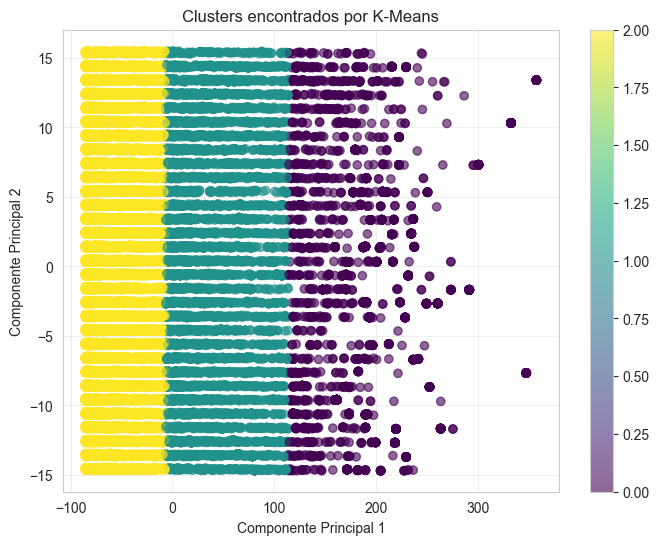

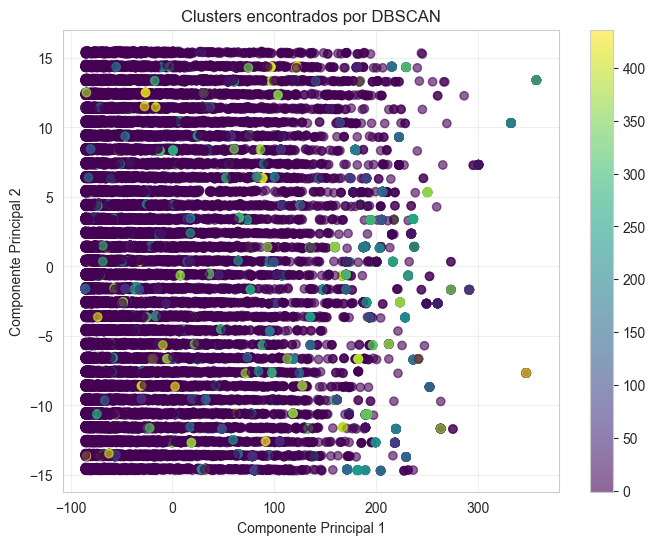

In [109]:
# Gráficos de clustering para modelos no supervisados
# K-Means y DBSCAN con PCA 
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficos de clustering de K-Means y DBSCAN
for name, model in unsupervised_models.items():
    clusters = model.fit_predict(X_train_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.title(f'Clusters encontrados por {name}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar()
    plt.grid(alpha=0.3)
    plt.show()

Etapa 4: Selección del Mejor Modelo entre los 7


In [110]:
# Evaluo con validación cruzada (5 folds, usando RMSE)

print("\nEvaluación con validación cruzada:")

for name, model in supervised_models.items():
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_cv = -scores.mean()  

    print(f"{name} - RMSE promedio en validación cruzada: {rmse_cv:.2f}")


Evaluación con validación cruzada:
Linear Regression - RMSE promedio en validación cruzada: 24.26
Decision Tree - RMSE promedio en validación cruzada: 19.34
Random Forest - RMSE promedio en validación cruzada: 14.79
XGBoost - RMSE promedio en validación cruzada: 15.22
CatBoost - RMSE promedio en validación cruzada: 14.23


### Elijo RandomForestRegressor por facilidad y claridad en el trabajo.

In [111]:
print("Variables utilizadas en el modelo:")
print(X_train.columns.tolist())

Variables utilizadas en el modelo:
['required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7', 'market_segment_type_Complementary', 'market_segment_type_Corporate', 'market_segment_type_Offline', 'market_segment_type_Online', 'booking_status_Not_Canceled', 'total_guests', 'total_nights']


In [112]:
# Creo DataFrame con resultados supervisados
supervised_df = pd.DataFrame.from_dict(supervised_results, orient='index')[['rmse', 'mae', 'r2']]
supervised_df['Tipo'] = 'Supervisado'

# Creo DataFrame con resultados no supervisados 
unsupervised_df = pd.DataFrame.from_dict(unsupervised_results, orient='index')[['silhouette_score']]
unsupervised_df.rename(columns={'silhouette_score': 'score'}, inplace=True)  
unsupervised_df['Tipo'] = 'No Supervisado'

# Uno los resultados en un solo DataFrame
results_df = pd.concat([supervised_df, unsupervised_df], axis=0)

# Muestro resultados ordenados por el mejor desempeño en cada tipo
print("\nResumen de resultados:")
print(results_df.sort_values(by=['Tipo', 'rmse', 'score'], ascending=[True, True, False]))


Resumen de resultados:
                        rmse        mae        r2            Tipo     score
K-Means                  NaN        NaN       NaN  No Supervisado  0.591331
DBSCAN                   NaN        NaN       NaN  No Supervisado -0.550814
CatBoost           14.617392   8.026417  0.824511     Supervisado       NaN
Random Forest      15.198949   7.514947  0.810269     Supervisado       NaN
XGBoost            15.771000   9.452414  0.795719     Supervisado       NaN
Decision Tree      19.863689   8.849085  0.675936     Supervisado       NaN
Linear Regression  24.674731  17.891204  0.499948     Supervisado       NaN


In [126]:
import numpy as np

# Cargar tu CSV original (si ya lo tienes)
df = pd.read_csv("resultados_modelos.csv")

# Reemplazar NaN por 0 o dejar vacío (según lo que acepte la herramienta)
df.fillna(0, inplace=True)  # Opción 1: Rellenar con 0
# df = df.replace(np.nan, "", regex=True)  # Opción 2: Dejar vacío (depende de la herramienta)

# Guardar el CSV limpio
df.to_csv("resultados_modelos_limpio.csv", index=False)

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1727857407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['rmse'], palette="Blues_r")


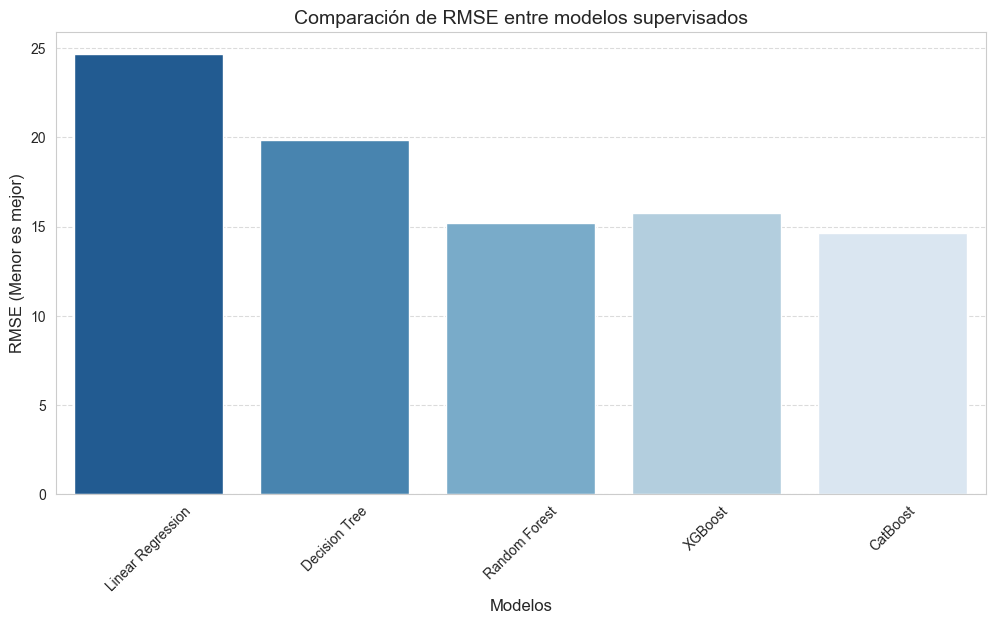

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1727857407.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['mae'], palette="Greens_r")


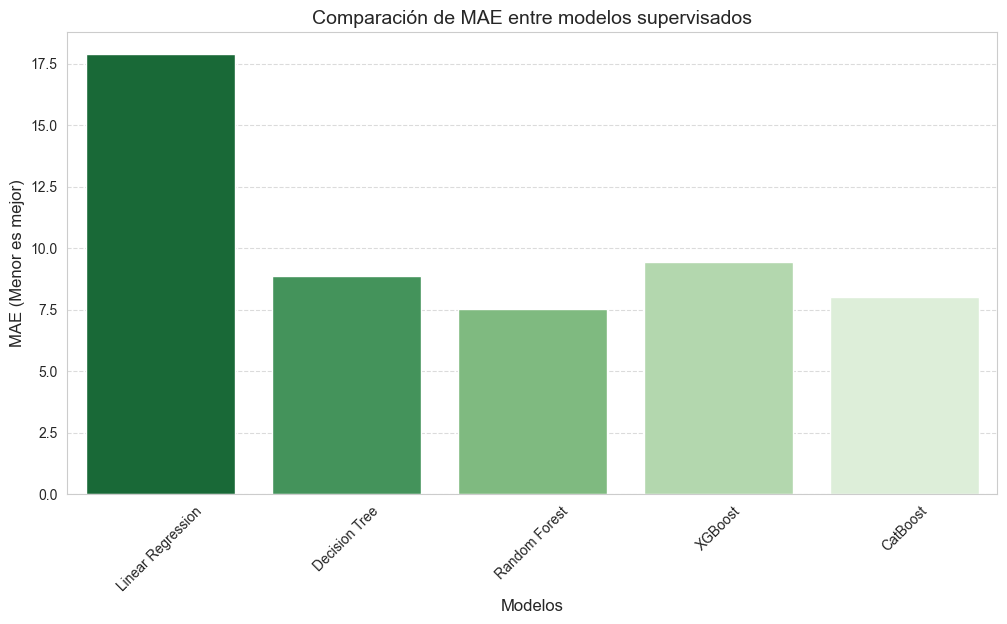

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1727857407.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['r2'], palette="coolwarm")


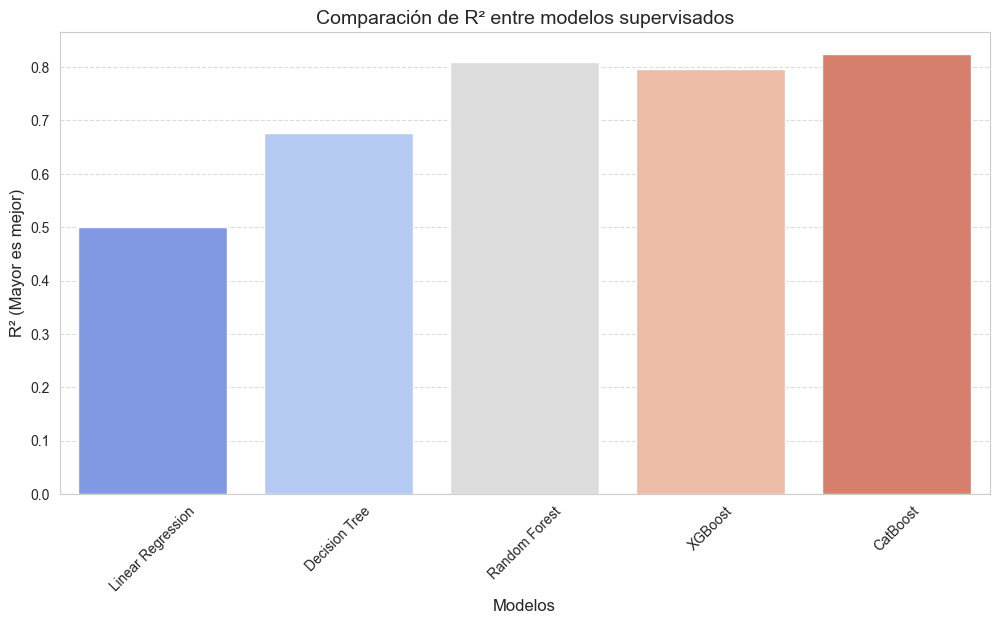

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1727857407.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df[results_df['Tipo'] == 'No Supervisado'].index, y=results_df[results_df['Tipo'] == 'No Supervisado']['score'], palette="Oranges_r")


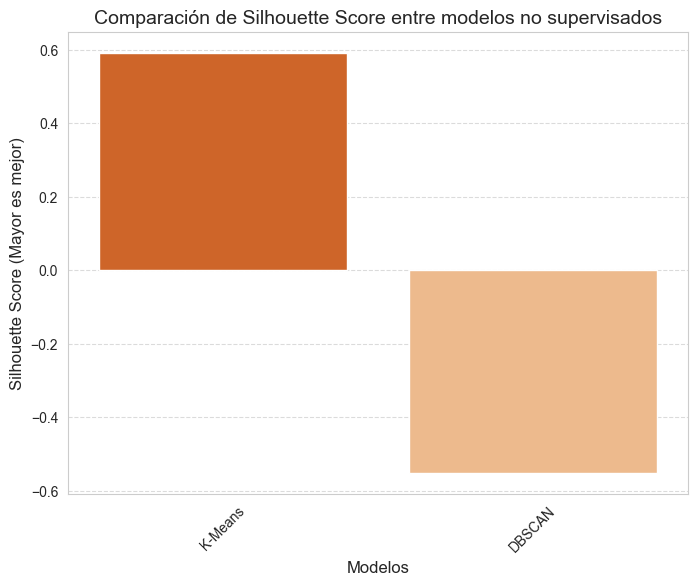

In [113]:
# Configurar el tamaño de los gráficos
plt.figure(figsize=(12, 6))

# Gráfico de barras para RMSE de modelos supervisados
sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['rmse'], palette="Blues_r")
plt.title("Comparación de RMSE entre modelos supervisados", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("RMSE (Menor es mejor)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para MAE de modelos supervisados
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['mae'], palette="Greens_r")
plt.title("Comparación de MAE entre modelos supervisados", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("MAE (Menor es mejor)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para R² de modelos supervisados
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df[results_df['Tipo'] == 'Supervisado'].index, y=results_df[results_df['Tipo'] == 'Supervisado']['r2'], palette="coolwarm")
plt.title("Comparación de R² entre modelos supervisados", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("R² (Mayor es mejor)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Comparación de modelos no supervisados con Silhouette Score
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df[results_df['Tipo'] == 'No Supervisado'].index, y=results_df[results_df['Tipo'] == 'No Supervisado']['score'], palette="Oranges_r")
plt.title("Comparación de Silhouette Score entre modelos no supervisados", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Silhouette Score (Mayor es mejor)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

No elijo K-Means para el recomendador de precios porque, aunque tiene un Silhouette Score de 0.59, es un modelo no supervisado que agrupa datos en categorías en lugar de predecir valores numéricos como el precio de una habitación.


Opto por Random Forest, que con un RMSE de 15.20 y un R² de 0.81, ofrece una mejor capacidad predictiva y facilidad de interpretación.

Ajuste de hiperparámetros con Optuna para RandomForestRegressor

In [117]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Defino la función objetivo que Optuna optimizará
def objective(trial):
    # Sugiero valores para cada hiperparámetro
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300])
    max_depth = trial.suggest_categorical("max_depth", [10, 20, 30])
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])
    
    # Creo el modelo usando los hiperparámetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Realizo validación cruzada para estimar el rendimiento
    # Uso 'neg_root_mean_squared_error', luego invierto el signo para obtener el RMSE
    rmse = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()
    return rmse

# Creo el estudio en Optuna para minimizar el RMSE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Puedes aumentar n_trials para una búsqueda más exhaustiva

# Muestro los mejores hiperparámetros encontrados
print("✅ Mejores hiperparámetros encontrados:", study.best_params)

# Con los mejores hiperparámetros, entreno el mejor modelo
best_rf_model = RandomForestRegressor(**study.best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

[I 2025-05-15 18:22:45,162] A new study created in memory with name: no-name-157da086-da35-4ae0-ba2a-0f8e176d25d6
[I 2025-05-15 18:24:26,152] Trial 0 finished with value: 14.722308029876512 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 14.722308029876512.
[I 2025-05-15 18:25:11,499] Trial 1 finished with value: 19.656504059570153 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 14.722308029876512.
[I 2025-05-15 18:25:34,461] Trial 2 finished with value: 15.489445484670815 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 14.722308029876512.
[I 2025-05-15 18:26:41,193] Trial 3 finished with value: 15.4890428574715 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value

✅ Mejores hiperparámetros encontrados: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}


RandomForestRegressor(max_depth=30, n_estimators=300, random_state=42)


Ajuste de hiperparámetros con GridSearchCV para RandomForestRegressor



In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# **Definir la malla de hiperparámetros**
param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_depth': [10, 20, 30],        
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

# **Crear el modelo base**
rf = RandomForestRegressor(random_state=42)

# **Ejecutar GridSearchCV**
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# **Guardar el mejor modelo optimizado**
best_rf_model = grid_search.best_estimator_
print("✅ Mejores hiperparámetros encontrados para Random Forest:", grid_search.best_params_)

✅ Mejores hiperparámetros encontrados para Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Evalúo el modelo entrenado

In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔍 Evaluación del Mejor Random Forest:\n RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

🔍 Evaluación del Mejor Random Forest:
 RMSE: 15.19, MAE: 7.52, R²: 0.81


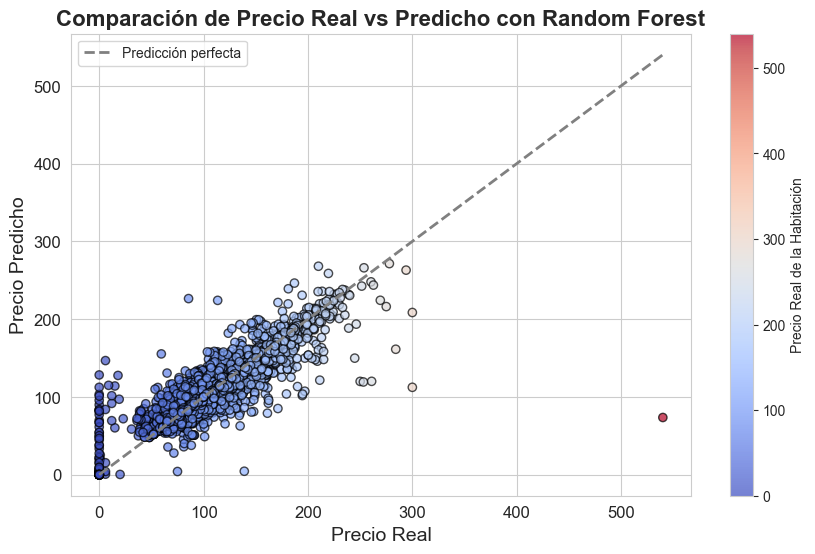

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura y estilo
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Gráfico de dispersión con mejor diseño
cmap = sns.color_palette("coolwarm", as_cmap=True)
scatter = plt.scatter(y_test, y_pred, c=y_test, cmap=cmap, alpha=0.7, edgecolors="black")

# Barra de colores para interpretar valores
plt.colorbar(scatter, label="Precio Real de la Habitación")

# Línea de referencia (predicción perfecta)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="gray", linestyle="--", linewidth=2, label="Predicción perfecta")

# Etiquetas y estilo
plt.xlabel("Precio Real", fontsize=14)
plt.ylabel("Precio Predicho", fontsize=14)
plt.title("Comparación de Precio Real vs Predicho con Random Forest", fontsize=16, fontweight="bold")
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\3012710380.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importancia (%)"], y=feature_importance["Variable"], palette="cividis", edgecolor="black")
C:\Users\JUAN\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


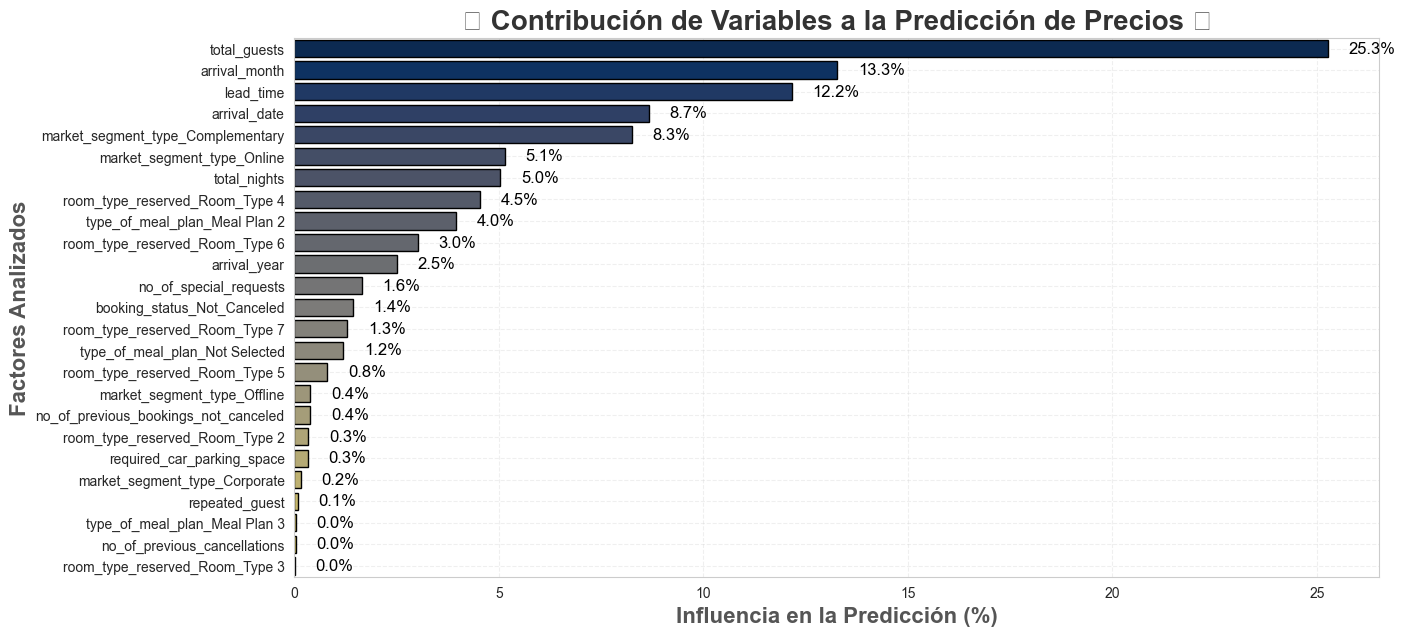

In [124]:
# Calcular el porcentaje de influencia
feature_importance["Importancia (%)"] = feature_importance["Importancia"] / feature_importance["Importancia"].sum() * 100

# Graficar
plt.figure(figsize=(14, 7))
sns.barplot(x=feature_importance["Importancia (%)"], y=feature_importance["Variable"], palette="cividis", edgecolor="black")

# Añadir anotaciones con valores
for index, value in enumerate(feature_importance["Importancia (%)"]):
    plt.text(value + 0.5, index, f"{value:.1f}%", fontsize=12, color="black", verticalalignment="center")

plt.title("🔹 Contribución de Variables a la Predicción de Precios 🔹", fontsize=20, fontweight="bold", color="#333")
plt.xlabel("Influencia en la Predicción (%)", fontsize=16, fontweight="bold", color="#555")
plt.ylabel("Factores Analizados", fontsize=16, fontweight="bold", color="#555")
plt.grid(alpha=0.3, linestyle="--")
plt.show()

Guardo el modelo para cargarlo en producción

In [66]:
import joblib

joblib.dump(best_rf_model, "../models/random_forest_trained.pkl")


['../models/random_forest_trained.pkl']

"Capturas" rendimiento del modelo a CSV e imagen

C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1895839062.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Valor", y="Métrica", data=rf_results, palette="viridis", edgecolor="black")
C:\Users\JUAN\AppData\Local\Temp\ipykernel_10552\1895839062.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(r"C:\Users\JUAN\Desktop\BOOTCAMP - DATA SCIENCE\Ejercicios Juan\Optimus_Price_proyecto_final_ML\docs\img\random_forest_performance.png")
C:\Users\JUAN\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


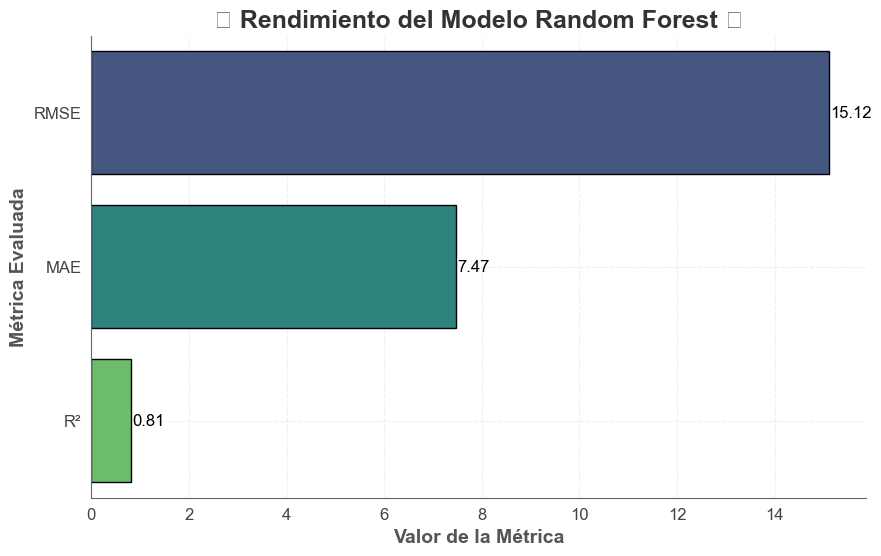

In [98]:
rf_results = pd.DataFrame({'Métrica': ['RMSE', 'MAE', 'R²'], 'Valor': [rmse, mae, r2]})

plt.figure(figsize=(10, 6))
sns.barplot(x="Valor", y="Métrica", data=rf_results, palette="viridis", edgecolor="black")
for index, value in enumerate(rf_results["Valor"]):
    plt.text(value + 0.02, index, f"{value:.2f}", fontsize=12, color="black", verticalalignment="center")

plt.title(" Rendimiento del Modelo Random Forest ", fontsize=18, fontweight="bold", color="#333")
plt.xlabel("Valor de la Métrica", fontsize=14, fontweight="bold", color="#555")
plt.ylabel("Métrica Evaluada", fontsize=14, fontweight="bold", color="#555")
plt.grid(alpha=0.3, linestyle="--")

plt.xticks(fontsize=12, color="#444")
plt.yticks(fontsize=12, color="#444")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#666")
plt.gca().spines["bottom"].set_color("#666")

plt.savefig(r"C:\Users\JUAN\Desktop\BOOTCAMP - DATA SCIENCE\Ejercicios Juan\Optimus_Price_proyecto_final_ML\docs\img\random_forest_performance.png")
plt.show()